In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines

# Data Preprocessing

In [2]:
# download airport info data
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", 
                         names = airport_col, index_col = 0)

In [3]:
airport_df.head(3)

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
# download flight routes data
route_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID', 
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = route_cols)

In [5]:
routes_df.head(3)

,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2


In [6]:
# clean up data, change 'object' type to numeric and drops NaNs
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 

# Simple network visualization
- Alaska and other non-mainlain territories included 

In [7]:
airport_us = airport_df[(airport_df.Country == "United States")][['Name','Lat', 'Long', 'IATA', 'ICAO']]
us_airport_ix = airport_us.index.values

In [8]:
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

In [9]:
routes_us.head()

,Source Airport,Dest Airport,counts
0,ABE,ATL,3
1,ABE,CLT,2
2,ABE,DTW,1
3,ABE,MYR,1
4,ABE,ORD,1


To find number of flights in and out of an airport, it is similar to find number of rows in which each airport occur in either one of the 2 columns

In [10]:
counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()

In [11]:
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
pos_data = counts.merge(airport_us, on = 'IATA')

In [12]:
pos_data.head()

,IATA,total_flight,Name,Lat,Long,ICAO
0,ATL,305,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,KATL
1,ORD,295,Chicago O'Hare International Airport,41.978600,-87.904800,KORD
2,DEN,293,Denver International Airport,39.861698,-104.672997,KDEN
3,DFW,274,Dallas Fort Worth International Airport,32.896801,-97.038002,KDFW
4,MSP,232,Minneapolis-St Paul International/Wold-Chamber...,44.882000,-93.221802,KMSP


In [13]:
routes_us.head()

,Source Airport,Dest Airport,counts
0,ABE,ATL,3
1,ABE,CLT,2
2,ABE,DTW,1
3,ABE,MYR,1
4,ABE,ORD,1


In [14]:
# Create graph
graph = nx.from_pandas_edgelist(routes_us, source = 'Source Airport', target = 'Dest Airport',
                                edge_attr = 'counts', create_using = nx.DiGraph())

In [15]:
graph

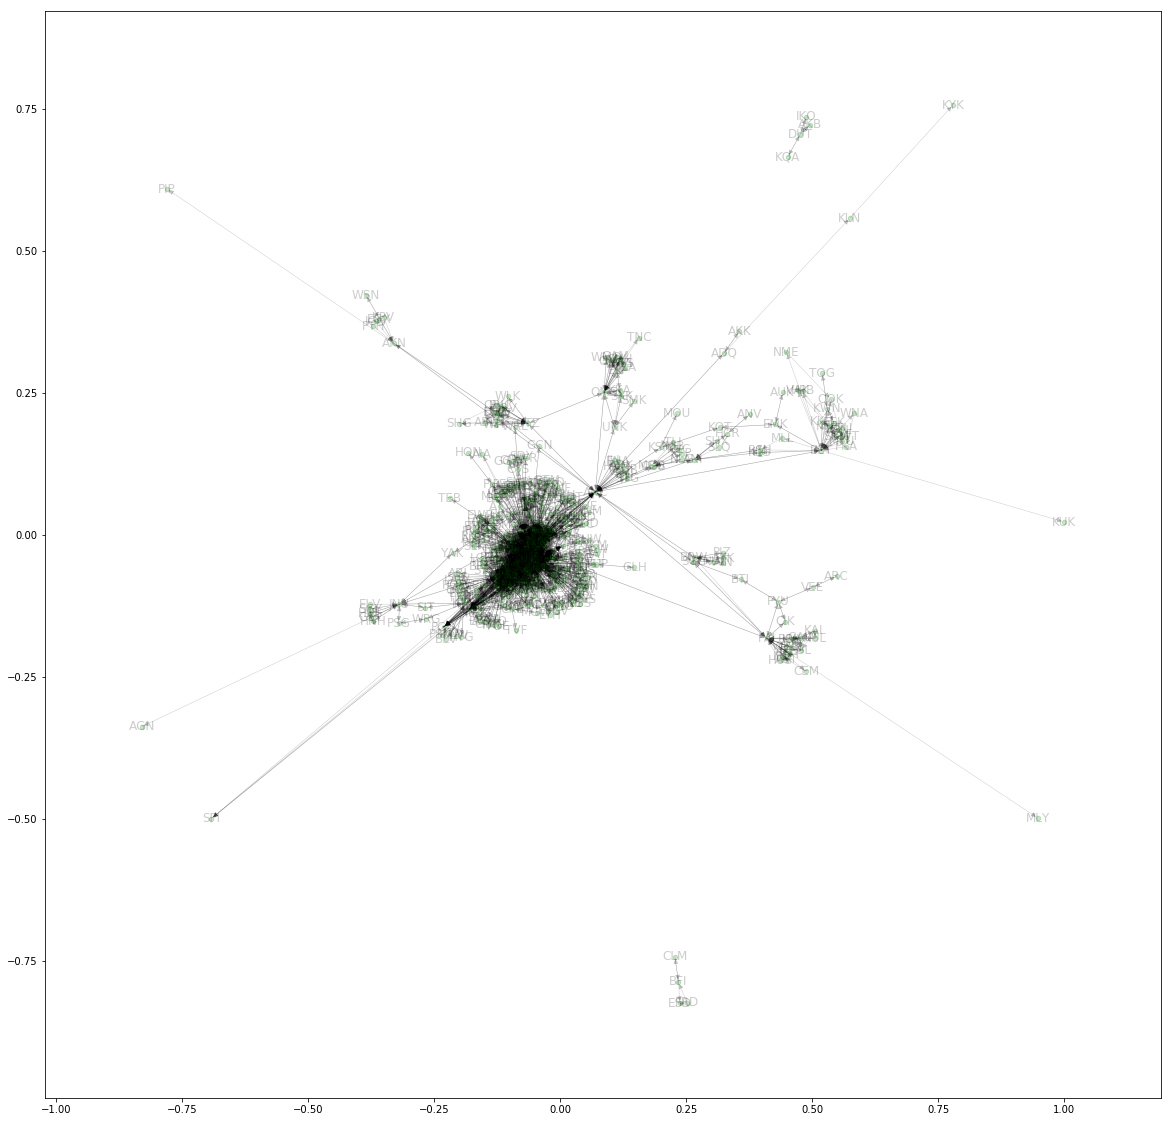

In [16]:
# default graph using Networkx inbuilt graph tools
plt.figure(figsize = (20, 20))
nx.draw_networkx(graph, node_size = 20, node_color = "green", alpha = 0.2, width = 0.5)
plt.savefig("map_0.png", format = "png", dpi = 300)
plt.show()

In [17]:
airport_us = airport_df[(airport_df.Country == "United States") & (airport_df.Lat > 25) 
                        & (airport_df.Lat < 50) & (airport_df.Long > -130) & (airport_df.Long < -60)]
us_airport_ix = airport_us.index.values
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))] #extract routes that flyies from AND to USA
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

In [18]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns
counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
pos_data = counts.merge(airport_us, on = 'IATA')

In [19]:
# Create graph
graph = nx.from_pandas_edgelist(routes_us, source = 'Source Airport', target = 'Dest Airport',
                        edge_attr = 'counts',create_using = nx.DiGraph())

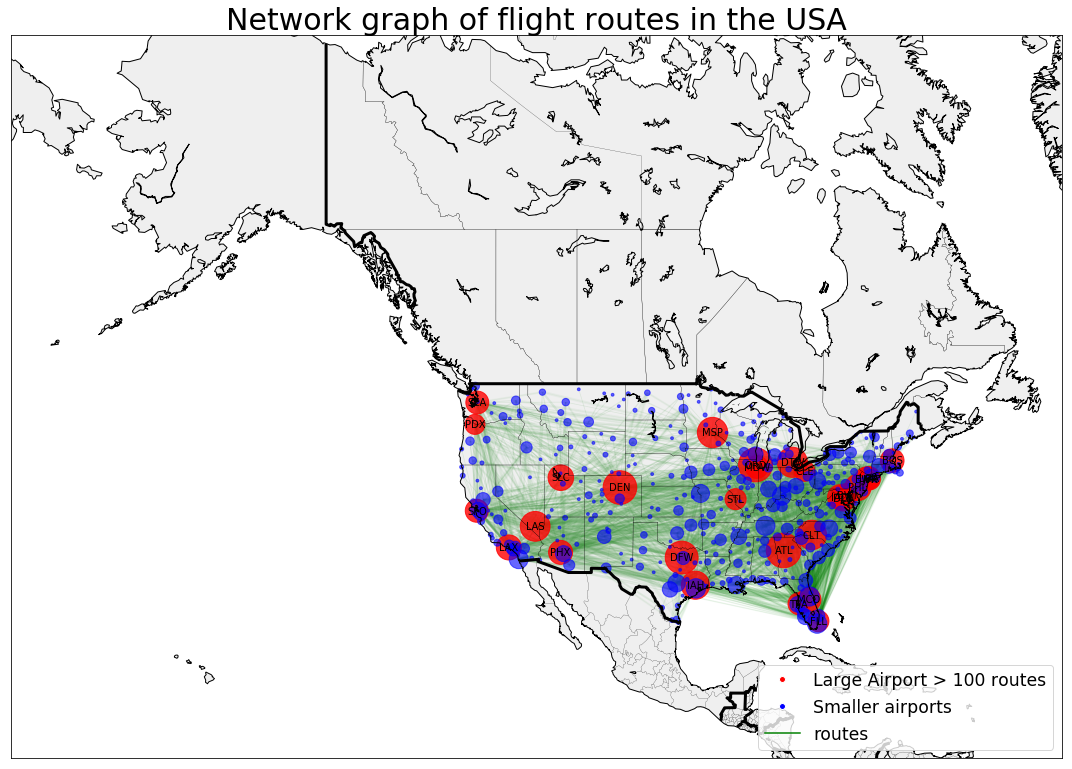

successful visualization


In [20]:
# Set up base map
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-180,
        llcrnrlat=10,
        urcrnrlon=-50,
        urcrnrlat=70,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

# import long lat as m attribute
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

# draw nodes and edges and overly on basemap
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 100],
                       node_color = 'r', alpha = 0.8,
                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 100])

nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 100})

nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 100],
                       node_color = 'b', alpha = 0.6,
                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 100])

nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = routes_us['counts']*0.75, 
                       alpha=0.06, arrows = False)

m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(alpha = 0.3)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2, line3), ('Large Airport > 100 routes', 'Smaller airports', 'routes'),
           loc=4, fontsize = 'xx-large')
plt.title("Network graph of flight routes in the USA", fontsize = 30)
#m.bluemarble()
plt.tight_layout()
plt.savefig("map_3.png", format = "png", dpi = 300)
plt.show()
print ("successful visualization")